In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Sample images from: Defective


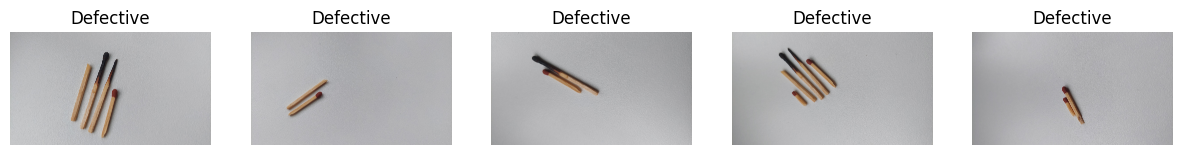


Sample images from: Non_Defective


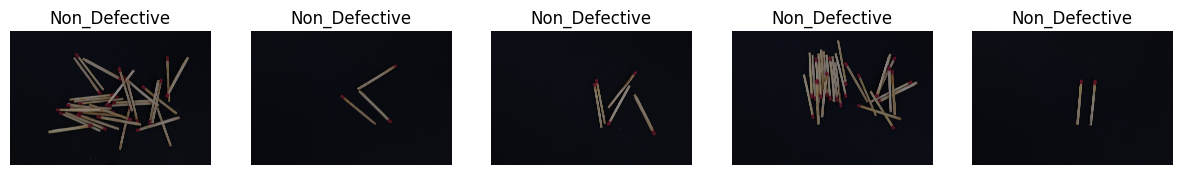

In [ ]:
# View some random images from each class
data_path = 'datasets/matchsticks_dataset'
classes = ['defective', 'non_defective']

for cls in classes:
    cls_path = os.path.join(data_path, cls)
    images = random.sample(os.listdir(cls_path), 5)

    print(f"\nSample images from: {cls}")
    plt.figure(figsize=(15, 2))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(cls_path, img_name))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls)
    plt.show()


In [ ]:
# ImageDataGenerator (with augmentation)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

augment_defective = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

no_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset

def load_images_from_folder(folder_path, label, datagen, augment_times=1):
    images, labels = [], []
    for fname in os.listdir(folder_path):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, target_size=IMG_SIZE)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            images.append(batch[0])
            labels.append(label)
            i += 1
            if i >= augment_times:
                break
    return np.array(images), np.array(labels)

# Load and augment defective images (label 0)
X_def, y_def = load_images_from_folder('datasets/matchsticks_dataset/defective', 0, augment_defective, augment_times=5)

# Load non_defective without augmentation (label 1)
X_non, y_non = load_images_from_folder('datasets/matchsticks_dataset/non_defective', 1, no_aug, augment_times=1)


In [ ]:
X = np.concatenate((X_def, X_non), axis=0)
y = np.concatenate((y_def, y_non), axis=0)

# Shuffle
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

In [ ]:
def build_simple_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


In [ ]:
def build_deeper_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


In [ ]:
def build_transfer_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
    base.trainable = False  # Freeze layers

    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
# Train and compare models
models = {
    'Simple CNN': build_simple_cnn(),
    'Deeper CNN': build_deeper_cnn(),
    'MobileNetV2': build_transfer_model()
}

# Automatically stop if there is no improvement in val_loss
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


results = {}

for name, model in models.items():
    print(f"\nTraining {name}")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stop]
    )

    val_acc = history.history['val_accuracy'][-1]
    results[name] = val_acc

    # Plot
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f"{name} Accuracy")
    plt.legend()
    plt.show()

In [ ]:
print("\nFinal Validation Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc*100:.2f}%")

In [ ]:
# Evaluate best model
final_model = models['MobileNetV2']
y_pred_probs = final_model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Defective', 'Non-defective'], yticklabels=['Defective', 'Non-defective'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Defective', 'Non-defective']))

In [ ]:
model.save("matchstick_classifier.h5")

NameError: name 'model' is not defined

: 

## Final Results Summary

### Objective
Classify **matchsticks** as either:
- Defective
- Non-defective

### Dataset Summary
- Total images used: **56 defective** vs **294 non-defective**
- Augmentation applied to **defective** class to address class imbalance
- Validation set size: **115 images** (balanced)

### Models Tested
1. **Simple CNN** — basic 2-layer ConvNet  
2. **Deeper CNN** — 4 Conv layers, 1 dense  
3. **MobileNetV2 (Transfer Learning)** — pretrained on ImageNet, with frozen base

### Best Performing Model
All 3 models being created give perfect **precision, recall, and F1-score** for both classes, so it's hard to determine the best one. 


### Takeaways
- Data augmentation **greatly helped** balance the dataset
- The model is now highly reliable and ready for real-world testing or deployment

